# Project 2 - Generalized Linear Models

## Yan Bo Zeng

This project has been uploaded on GitHub: https://github.com/uclayanbo/OptimizationProjects/blob/eb069a2e8ce2b690aeecc42d7cf105349e90407a/Project%202%20-%20Generalized%20Linear%20Models%20with%20Newton's%20Methods.ipynb

In [1]:
library(dplyr)
library(repr)
options(repr.plot.width = 12, repr.plot.height = 10)
options(scipen = 999)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




# 1. Ordinary Least Squares

Recall the ordinary least squares model $y_i = x_i'\beta + \epsilon_i$. The maximum likelihood estimator (MLE) for the coefficient parameter $\beta$ is
\begin{align*}
    \hat{\beta} & = \arg\max_{\beta \in \mathbb{R}^k} -\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2 \\
    & = \arg\min_{\beta \in \mathbb{R}^k} \frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2
\end{align*}

Denote $\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2 = Q(\beta)$, $X$ as the model matrix including the intercept term, and $Y$ as the outcome vector. Then, the gradient is
\begin{align*}
    \nabla Q(\beta) & = \frac{\partial}{\partial\beta} Q(\beta) \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)x_i \\
    & = -\frac{1}{n} X'\left(Y - X\beta \right)
\end{align*}

The Hessian is
\begin{align*}
    \nabla^2 Q(\beta) & = \frac{1}{n} X'X \\
    & \succeq 0
\end{align*}

In [2]:
#Define the cost, gradient, and Hessian functions for OLS.
OLS_cost <- function(X, y, beta) {
    return(mean((y - X %*% beta)^2) / 2)
}

OLS_gradient <- function(X, y, beta) {
    return(-t(X) %*% (y - X %*% beta) / length(y))
}

OLS_hessian <- function(X, y, beta) {
    return(t(X) %*% X / length(y))
}

### Gradient Descent
Given a learning rate $\alpha_t$, gradient descent will iterate on
\begin{align*}
    \hat{\beta}_{t+1} & = \hat{\beta}_{t} - \alpha_t \nabla Q(\hat{\beta}_{t}) \\
    & = \hat{\beta}_{t} + \alpha_t \frac{1}{n} X'\left(Y - X\hat{\beta}_{t} \right)
\end{align*}

In [3]:
#Define the gradient descent function.
gradient_descent <- function(X, y, beta_init = rep(0, ncol(X)), num_iters = 200, alpha = 0.1,
                             error_func = OLS_cost, grad_func = OLS_gradient, linesearch = FALSE, linesearch_c = 0.8) {
    
    #Record errors (cost values) from each iteration.
    error_history <- rep(0, num_iters)
    
    #Initialize beta.
    beta <- beta_init
    
    #Record alpha for line search.
    alpha_init <- alpha
    
    #Implement gradient descent.
    for (i in 1:num_iters) {
        error_old <- error_func(X, y, beta)
        delta <- grad_func(X, y, beta)
        beta <- beta - alpha * delta
        
        #Implement backtracking line search.
        if (linesearch == TRUE) {
            while (error_func(X, y, beta) > (error_old - linesearch_c*alpha*(norm(delta)^2))) {
                error_old <- error_func(X, y, beta)
                alpha = alpha / 2
                delta <- grad_func(X, y, beta)
                beta <- beta - alpha * delta
            }
            alpha <- alpha_init
        }
        
        error_history[i] <- error_func(X, y, beta)
    }
    
    #Return the history for plotting.
    return(list(beta, error_history))
}

### Newton's Method
The Newton's method will iterate on
\begin{align*}
    \hat{\beta}_{t+1} & = \hat{\beta}_{t} - \left(\nabla^2 Q(\hat{\beta}_{t}) \right)^{-1} \nabla Q(\hat{\beta}_{t})
\end{align*}

In [4]:
#Define the Newton's method function.
newton_method <- function(X, y, beta_init = rep(0, ncol(X)), num_iters = 200,
                          error_func = OLS_cost, grad_func = OLS_gradient, hessian_func = OLS_hessian) {
    
    #Record errors (cost values) from each iteration.
    error_history <- rep(0, num_iters)
    
    #Initialize beta.
    beta <- beta_init
    
    #Implement Newton's method.
    for (i in 1:num_iters) {
        delta <- solve(hessian_func(X, y, beta)) %*% grad_func(X, y, beta)
        beta <- beta - delta
        error_history[i] <- error_func(X, y, beta)
    }
    
    #Return the history for plotting.
    return(list(beta, error_history))
}

### BFGS
BFGS will start with an inverse Hessian approximation $H_0 = I_k$, where $k$ is the dimension of $\beta$.

Given a learning rate $\alpha_t$ which is obtained from backtracking line search for $t > 0$, we define
\begin{align*}
    \hat{\beta}_{t+1} & = \hat{\beta}_{t} - \alpha_t H_t \nabla Q(\hat{\beta}_{t}) \\
    s_t & = \hat{\beta}_{t+1} - \hat{\beta}_{t} \\
    y_t & = \nabla Q(\hat{\beta}_{t+1}) - \nabla Q(\hat{\beta}_{t}) \\
    \rho_t & = \frac{1}{y_t' s_t}
\end{align*}

Then, update $H_{t+1} = \left(I_k - \rho_t s_t y_t' \right) H_t \left(I_k - \rho_t y_t s_t' \right) + \rho_t s_t s_t'$.

In [5]:
#Define the BFGS function.
bfgs <- function(X, y, beta_init = rep(0, ncol(X)), num_iters = 200, alpha = 0.1, linesearch_c = 0.8,
                 error_func = OLS_cost, grad_func = OLS_gradient) {
    
    #Record errors (cost values) from each iteration.
    error_history <- rep(0, num_iters)
    
    #Initialize beta.
    beta <- beta_init
    
    #Record alpha for line search.
    alpha_init <- alpha
    
    #Initialize the inverse Hessian approximation with identity.
    n <- ncol(X)
    H <- diag(n)
    
    #Implement BFGS.
    for (i in 1:num_iters) {
        delta <- H %*% grad_func(X, y, beta)
        beta_new <- beta - alpha * delta
        
        #Implement backtracking line search.
        while (error_func(X, y, beta_new) >
               (error_func(X, y, beta) - linesearch_c * alpha * (t(grad_func(X, y, beta)) %*% delta))) {
            alpha = alpha / 2
        }
        
        sk <- beta_new - beta
        yk <- grad_func(X, y, beta_new) - grad_func(X, y, beta)
        
        #Sherman-Morrison-Woodbury.
        rho <- c(1 / (t(yk) %*% sk))
        
        #Update the inverse Hessian approximation.
        H <- (diag(n) - rho * sk %*% t(yk)) %*% H %*% (diag(n) - rho * yk %*% t(sk)) + rho * sk %*% t(sk)
        
        #Update beta and reset alpha.
        beta <- beta_new
        alpha <- alpha_init
        error_history[i] <- error_func(X, y, beta)
    }
    
    #Return the history for plotting.
    return(list(beta, error_history))
}

### Conjugate Gradients



In [6]:
inner <- function(x, y) {
    return(as.numeric(as.numeric(x) %*% as.numeric(y)))
}

conjugate_gradient <- function(X, y, num_iters = 200, error_func = OLS_cost) {
    error_history <- rep(0, num_iters)
    A <- t(X) %*% X
    b <- t(X) %*% y
    
    n <- dim(A)[1]
    x <- numeric(n)
    r <- b - A %*% x
    p <- r
    r_old <- inner(r, r)
    
    for (i in 1:num_iters) {
        alpha <- r_old / inner(p, (A %*% p))
        x <- x + alpha * p
        r <- r - alpha * A %*% p
        r_new <- inner(r, r)
        if (sqrt(r_new) < 1e-10)
            break
        beta <- r_new / r_old
        p <- r + beta * p
        r_old <- r_new
        
        error_history[i] <- error_func(X, y, x)
    }
    
    #Return the history for plotting.
    return(list(x, error_history))
}

## Test the algorithm on orange juice advertisement data.
Firstly, we can use the R built-in glm() package to obtain a robust estimate of the coefficients.

In [7]:
oj <- read.csv("C:/Users/yanbo/OneDrive/Stanford MS&E 311 Optimization/oj.csv")
X <- model.matrix(log(sales) ~ log(price) + brand, data = oj)
y <- log(oj$sales)

builtin <- glm(log(sales) ~ log(price) + brand, data = oj)
coef(builtin) %>% as.matrix()

(Intercept),10.8288216
log(price),-3.1386914
brandminute.maid,0.8701747
brandtropicana,1.5299428


In [8]:
betalist_gd2_ls <- gradient_descent(X, y, alpha = 2, linesearch = TRUE)
betalist_gd01_ls <- gradient_descent(X, y, linesearch = TRUE)
betalist_newton <- newton_method(X, y)
betalist_bfgs <- bfgs(X, y)
betalist_cg <- conjugate_gradient(X, y)

display <- cbind(betalist_gd2_ls[[1]], betalist_gd01_ls[[1]], betalist_newton[[1]], betalist_bfgs[[1]], betalist_cg[[1]])
colnames(display) <- c("GD, line search, alpha = 2", "GD, line search, alpha = 0.1", "Newton's", "BFGS, alpha = 0.1", "CG")
display

,"GD, line search, alpha = 2","GD, line search, alpha = 0.1",Newton's,"BFGS, alpha = 0.1",CG
(Intercept),10.8288216,9.7142440,10.8288216,10.8288217,10.8288216
log(price),-3.1386914,-1.0204047,-3.1386914,-3.1386915,-3.1386914
brandminute.maid,0.8701746,0.2811513,0.8701747,0.8701745,0.8701747
brandtropicana,1.5299428,0.3799773,1.5299428,1.5299427,1.5299428


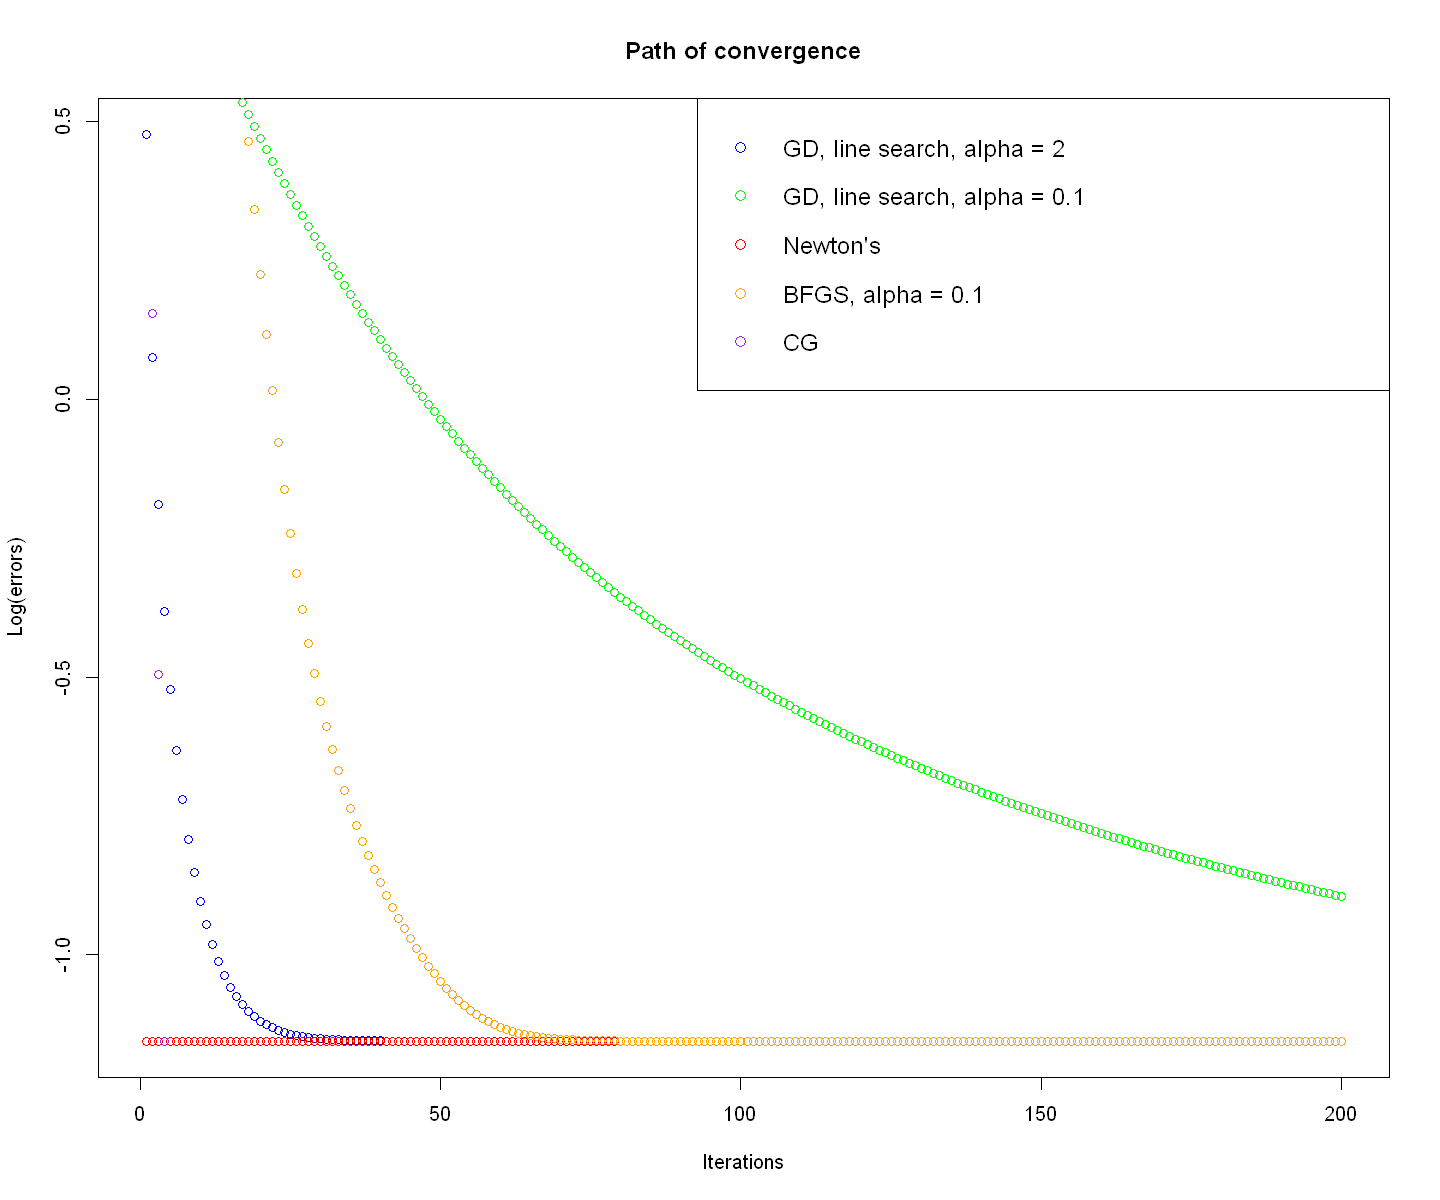

In [9]:
#Visualize the path of convergence.
plot(log(betalist_gd2_ls[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist_gd01_ls[[2]]), col = 'green')
points(log(betalist_newton[[2]]), col = 'red')
points(log(betalist_bfgs[[2]]), col = 'orange')
points(log(betalist_cg[[2]]), col = 'purple')
legend("topright", col = c("blue", "green", "red", "orange", "purple"), bty = "o", pch = 1, cex = 1.2,
       legend = c("GD, line search, alpha = 2", "GD, line search, alpha = 0.1", "Newton's", "BFGS, alpha = 0.1", "CG"))

From Project 1, we learned that the best configuration for gradient descent was line search combined with a learning rate $\alpha_t = 2$. When we tried to use $\alpha_t = 2$ for BFGS, we found that the line search part of the algorithm would take an insane amount of time to run. Therefore, we switched to some lower $\alpha_t$ (e.g., $\le 0.3$), and BFGS started to perform efficiently. We can see that at the same learning rate $\alpha_t = 0.1$, BFGS significantly outperformed gradient descent.

Although it is hard to see, we confirm that conjugate gradients converges in Rank($X'X$) iterations.

Noticeably, the convergence of Newton's method looks very interesting for the OLS case, where $\hat{\beta} = \arg{\min\limits_\beta{\sum\limits_{i=1}^n{(y_i - x_i'\beta)^2}}}$, and $\sum\limits_{i=1}^n{x_ix_i'}$ is invertible.

Let $\beta \in \mathbb{R}^k$,
\begin{align*}
    \hat{Q}_n(\beta) & = \sum\limits_{i=1}^n{(y_i - x_i'\beta)^2} \\
    \frac{\partial \hat{Q}_n(\beta)}{\partial\beta} & = \sum\limits_{i=1}^n{2x_i(y_i - x_i'\beta)} = \sum\limits_{i=1}^n{2x_iy_i - 2x_ix_i'\beta} \\
    \frac{\partial^2 \hat{Q}_n(\beta)}{\partial\beta \partial\beta'} & = \sum\limits_{i=1}^n{-2x_ix_i'}
\end{align*}

Then, in just one iteration, the Newton's method will return the OLS solution:
\begin{align*}
    \hat{\beta} & = \beta - \left(\frac{\partial^2 \hat{Q}_n(\beta)}{\partial\beta \partial\beta'}\right)^{-1} \times \frac{\partial \hat{Q}_n(\beta)}{\partial\beta} \\
    & = \beta + \left(2\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \times 2\left(\sum\limits_{i=1}^n{x_iy_i} - \beta\sum\limits_{i=1}^n{x_ix_i'}\right) \\
    & = \beta - \left(2\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \left(2\beta\sum\limits_{i=1}^n{x_ix_i'}\right) + \left(2\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \left(2\sum\limits_{i=1}^n{x_iy_i}\right) \\
    & = \beta - \beta + \left(\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \left(\sum\limits_{i=1}^n{x_iy_i}\right) \\
    & = \left(\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \left(\sum\limits_{i=1}^n{x_iy_i}\right)
\end{align*}

# 2. Logistic and Probit Regressions

Recall that in logit and probit models, $\hat{\beta}$ is obtained by maximizing the log-likelihood function or equivalently minimizing the cross-entropy loss function.
\begin{align*}
    \hat{\beta} & = \arg\max_{\beta \in \mathbb{R}^k} \prod_{i=1}^{n} F(x_i'\beta)^{y_i} \left(1 - F(x_i'\beta) \right)^{1-y_i} \\
    & = \arg\min_{\beta \in \mathbb{R}^k} -\log{\left( \prod_{i=1}^{n} F(x_i'\beta)^{y_i} \left(1 - F(x_i'\beta) \right)^{1-y_i} \right)} \\
    & = \arg\min_{\beta \in \mathbb{R}^k} -\frac{1}{n} \sum_{i=1}^{n} \left(y_i\log{F(x_i'\beta)} + (1-y_i)\log{\left(1 - F(x_i'\beta) \right)} \right)
\end{align*}

Denote $-\frac{1}{n} \sum_{i=1}^{n} \left(y_i\log{F(x_i'\beta)} + (1-y_i)\log{\left(1 - F(x_i'\beta) \right)} \right) = Q(\beta)$. Then, the gradient is
\begin{align*}
    \nabla Q(\beta) & = \frac{\partial}{\partial\beta} Q(\beta) \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i}{F(x_i'\beta)} - \frac{1-y_i}{1-F(x_i'\beta)} \right) f(x_i'\beta)x_i \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \frac{y_i-F(x_i'\beta)}{F(x_i'\beta) \left(1-F(x_i'\beta) \right)} f(x_i'\beta)x_i
\end{align*}

The Hessian is
\begin{align*}
    \nabla^2 Q(\beta) & = -\frac{1}{n} \sum_{i=1}^{n} \frac{f(x_i'\beta)^2}{F(x_i'\beta) \left(1-F(x_i'\beta) \right)} x_i x_i'
\end{align*}

For logit, $F(x_i'\beta) = \frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}}$, and $f(x_i'\beta) = \left(\frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}} \right) \left(1 - \frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}} \right) = F(x_i'\beta) \left(1-F(x_i'\beta)\right)$.

For probit, $F(x_i'\beta) = \Phi(x_i'\beta)$, and $f(x_i'\beta) = \phi(x_i'\beta)$, where $\Phi(\cdot)$ and $\phi(\cdot)$ are the standard normal CDF and PDF, respectively.

In [10]:
#Define the cost and gradient functions for logit.
logit_cost <- function(X, y, beta) {
    return(-mean(y*log(exp(X%*%beta)/(1+exp(X%*%beta))) + (1-y)*log(1-exp(X%*%beta)/(1+exp(X%*%beta)))))
}

logit_gradient <- function(X, y, beta) {
    return(-t(X) %*% (y - exp(X%*%beta)/(1 + exp(X%*%beta))) / length(y))
}

logit_hessian <- function(X, y, beta) {
    H_hat <- matrix(0, nrow = ncol(X), ncol = ncol(X))
    for (i in 1:length(y)) {
        H_hat <- H_hat + -X[i, ] %*% t(X[i, ]) *
            as.numeric((1/(1+exp(-t(X[i, ])%*%beta))) * (1-(1/(1+exp(-t(X[i, ])%*%beta)))))
    }
    return(H_hat / length(y))
}

## Test the algorithm for logit on synthetic data.

In [11]:
set.seed(888)
n <- 10000
y <- runif(n) > 0.4
X <- cbind(Intercept = rep(1, n), x1 = rnorm(n, 0, 2), x2 = runif(n, -2, 1), x3 = rnorm(n, 4, 1), x4 = rnorm(n, -3, 5))
data <- data.frame(y, X)

builtin <- glm(y ~ x1 + x2 + x3 + x4, data = data, family = binomial(link = "logit"))
coef(builtin) %>% as.matrix()

(Intercept),0.4161762124
x1,0.0090180079
x2,-0.0318122563
x3,-0.0014710907
x4,0.0008547123


In [12]:
betalist_gd08_ls <- gradient_descent(X, y, alpha = 0.8, linesearch = TRUE, num_iters = 300,
                                     error_func = logit_cost, grad_func = logit_gradient)
betalist_gd01_ls <- gradient_descent(X, y, linesearch = TRUE, num_iters = 300,
                                     error_func = logit_cost, grad_func = logit_gradient)
betalist_bfgs <- bfgs(X, y, error_func = logit_cost, grad_func = logit_gradient, num_iters = 300)

display <- cbind(betalist_gd08_ls[[1]], betalist_gd01_ls[[1]], betalist_bfgs[[1]])
colnames(display) <- c("GD, line search, alpha = 0.8", "GD, line search, alpha = 0.1", "BFGS, alpha = 0.1")
display

,"GD, line search, alpha = 0.8","GD, line search, alpha = 0.1","BFGS, alpha = 0.1"
Intercept,0.4152896477,0.2322796413,0.4161762124
x1,0.0090203362,0.0095064768,0.0090180079
x2,-0.0318481777,-0.0392917096,-0.0318122563
x3,-0.0012704475,0.0401856108,-0.0014710907
x4,0.0008488198,-0.0003678496,0.0008547123


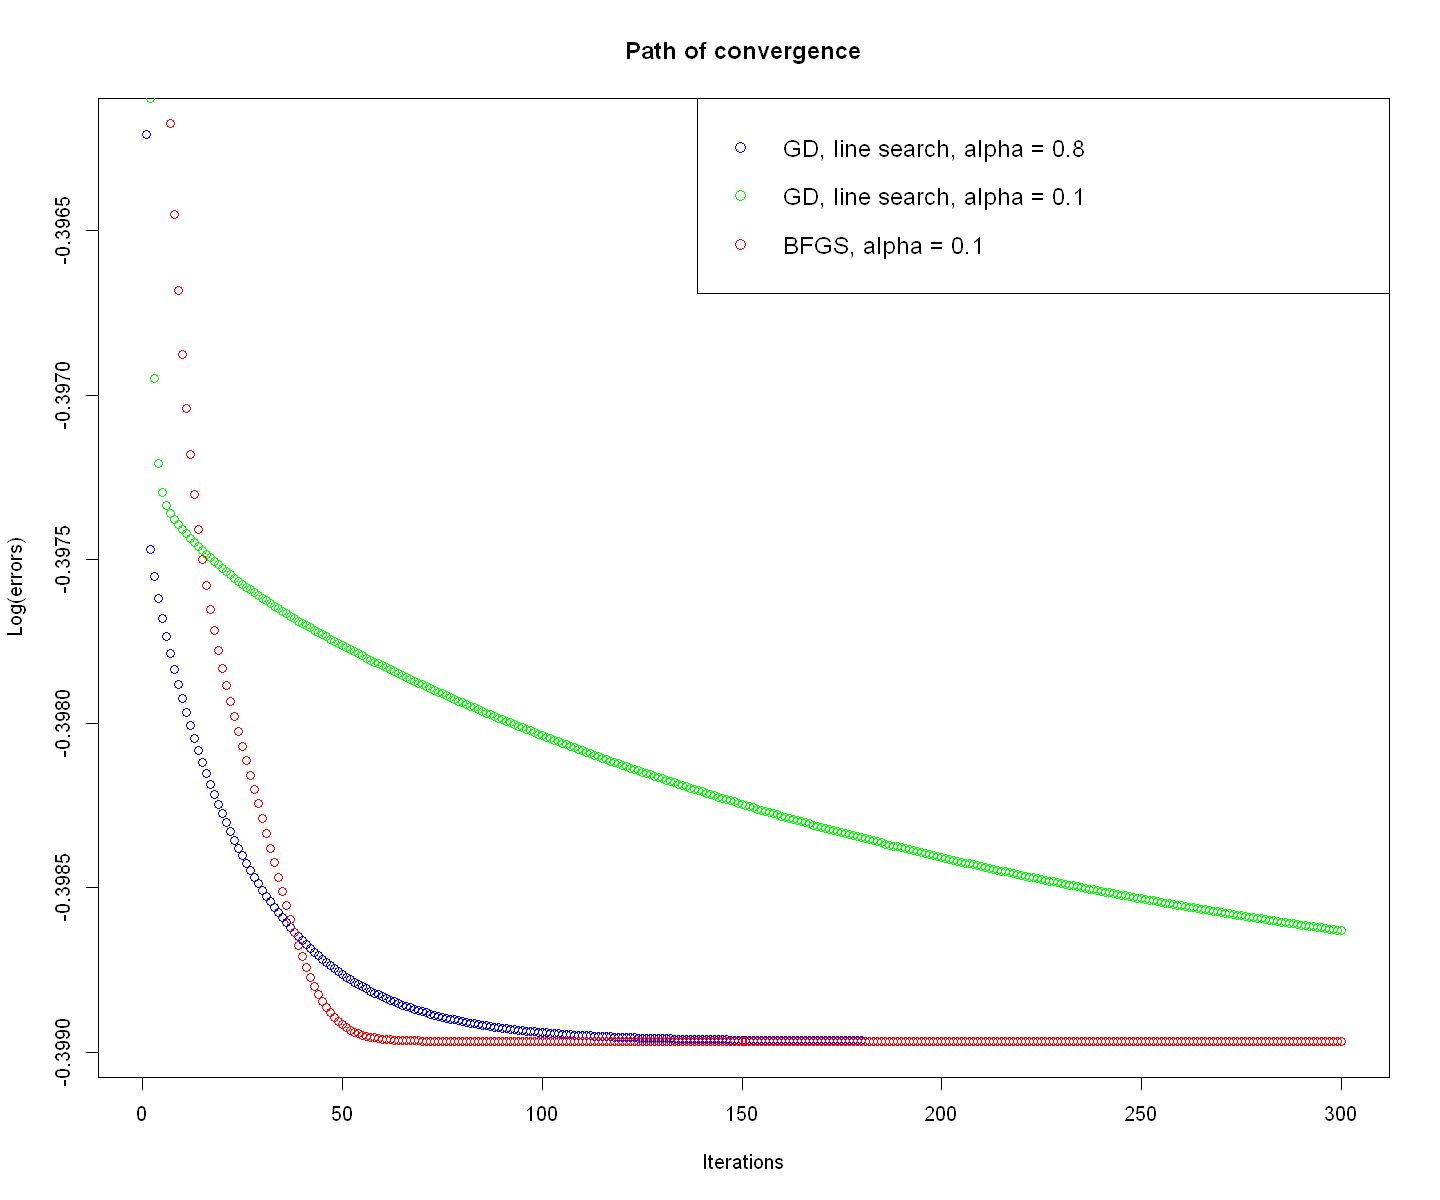

In [13]:
#Visualize the path of convergence.
plot(log(betalist_gd08_ls[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist_gd01_ls[[2]]), col = 'green')
points(log(betalist_bfgs[[2]]), col = 'red')
legend("topright", legend = c("GD, line search, alpha = 0.8", "GD, line search, alpha = 0.1", "BFGS, alpha = 0.1"),
       col = c("blue", "green", "red"), bty = "o", pch = 1, cex = 1.2)

In the logistic regression case, BFGS outperformed the best gradient descent configuration we got from Project 1, which was line search combined with $\alpha_t = 0.8$. It is also impressive that BFGS took less than $100$ iterations to converge on a logit model, which is in general much harder to fit than OLS. On the other hand, Newton's method is unusable here because the Hessian is not guaranteed to be positive definite or even invertible.

## Test the algorithm for probit.

In [14]:
#Define the cost and gradient functions for probit.
probit_cost <- function(X, y, beta) {
    return(-mean(y*log(pnorm(X%*%beta)) + (1-y)*log(1-pnorm(X%*%beta))))
}

probit_gradient <- function(X, y, beta) {
    return(-t(X) %*% ((y-pnorm(X%*%beta))/(pnorm(X%*%beta)*(1-pnorm(X%*%beta)))*dnorm(X%*%beta)) / length(y))
}

probit_hessian <- function(X, y, beta) {
    H_hat <- matrix(0, nrow = ncol(X), ncol = ncol(X))
    for (i in 1:length(y)) {
        H_hat <- H_hat + -X[i, ] %*% t(X[i, ]) *
            as.numeric((dnorm(t(X[i, ])%*%beta)^2) / (pnorm(t(X[i, ])%*%beta) * (1-pnorm(t(X[i, ])%*%beta))))
    }
    return(H_hat / length(y))
}

In [15]:
builtin <- glm(y ~ x1 + x2 + x3 + x4, data = data, family = binomial(link = "probit"))
coef(builtin) %>% as.matrix()

(Intercept),0.2599022393
x1,0.0055922210
x2,-0.0197340040
x3,-0.0008900177
x4,0.0005318751


In [ ]:
betalist_gd01_ls <- gradient_descent(X, y, linesearch = TRUE, num_iters = 10^3,
                                     error_func = probit_cost, grad_func = probit_gradient)
betalist_gd001_ls <- gradient_descent(X, y, alpha = 0.01, linesearch = TRUE, num_iters = 10^3,
                                      error_func = probit_cost, grad_func = probit_gradient)
betalist_bfgs <- bfgs(X, y, error_func = probit_cost, grad_func = probit_gradient, alpha = 0.01, num_iters = 10^3)

display <- cbind(betalist_gd01_ls[[1]], betalist_gd001_ls[[1]], betalist_bfgs[[1]])
colnames(display) <- c("GD, line search, alpha = 0.1", "GD, line search, alpha = 0.01", "BFGS, alpha = 0.01")
display

In [ ]:
#Visualize the path of convergence.
plot(log(betalist_gd01_ls[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist_gd001_ls[[2]]), col = 'green')
points(log(betalist_bfgs[[2]]), col = 'red')
legend("topright", legend = c("GD, line search, alpha = 0.1", "GD, line search, alpha = 0.01", "BFGS, alpha = 0.01"),
       col = c("blue", "green", "red"), bty = "o", pch = 1, cex = 1.2)

Firstly, Newton's method is also unusable in the probit case for the same reason. Compared with the logit case, both gradient descent and BFGS suffer from numeric overflow or underflow in the probit case due to the way R computes the standard normal densities (easy to get $1$ or $0$). When we used $\alpha_t \ge 0.4$ with gradient descent, the algorithm diverged to infinity fairly quickly. When we used $\alpha_t \ge 0.1$ with BFGS, the line search algorithm would take forever to run. If we compare the two methods at $\alpha_t = 0.01$, then BFGS performed way better than gradient descent.